构造一个完整的梯度下降算法
===

In [1]:
# 数据校验
def validate(X, Y):
    if len(X) != len(Y):
        raise Exception("参数异常")
    else:
        m = len(X[0])
        for l in X:
            if len(l) != m:
                raise Exception("参数异常")
        if len(Y[0]) != 1:
            raise Exception("参数异常")

# 计算差异值
def calcDiffe(x, y, a):
    # 计算ax - y的值
    lx = len(x)
    la = len(a)
    if lx == la:
        result = 0
        for i in range(lx):
            result += x[i] * a[i]
        return y - result
    elif lx + 1 == la:
        result = 0
        for i in range(lx):
            result += x[i] * a[i]
        result += 1 * a[lx] # 加上常数项
        return y - result
    else :
        raise Exception("参数异常")

                
## 要求X必须是List集合，Y也必须是List集合
def fit(X, Y, alphas, threshold=1e-6, maxIter=200, addConstantItem=True):
    import math
    import numpy as np
    ## 校验
    validate(X, Y)
    ## 开始模型构建
    l = len(alphas)
    m = len(Y)
    n = len(X[0]) + 1 if addConstantItem else len(X[0])#样本的个数
    B = [True for i in range(l)]#模型的格式：控制最优模型
    ## 差异性(损失值)
    J = [np.nan for i in range(l)]#loss函数的值
    # 1. 随机初始化0值(全部为0), a的最后一列为常数项
    a = [[0 for j in range(n)] for i in range(l)]#theta，是模型的系数
    # 2. 开始计算
    for times in range(maxIter):
        for i in range(l):
            if not B[i]:
                # 如果当前alpha的值已经计算到最优解了，那么不进行继续计算
                continue
            
            ta = a[i]
            for j in range(n):
                alpha = alphas[i]
                ts = 0
                for k in range(m):
                    if j == n - 1 and addConstantItem:
                        ts += alpha*calcDiffe(X[k], Y[k][0], a[i]) * 1
                    else:
                        ts += alpha*calcDiffe(X[k], Y[k][0], a[i]) * X[k][j]
                t = ta[j] + ts
                ta[j] = t
            ## 计算完一个alpha值的0的损失函数
            flag = True
            js = 0
            for k in range(m):
                js += math.pow(calcDiffe(X[k], Y[k][0], a[i]),2)
                if js > J[i]:
                    flag = False
                    break;
            if flag:
                J[i] = js
                for j in range(n):
                    a[i][j] = ta[j]
            else:
                # 标记当前alpha的值不需要再计算了
                B[i] = False     
        
        ## 计算完一个迭代，当目标函数/损失函数值有一个小于threshold的结束循环
        r = [0 for j in J if j <= threshold]
        if len(r) > 0:
            break
        # 如果全部alphas的值都结算到最后解了，那么不进行继续计算
        r = [0 for b in B if not b]
        if len(r) > 0:
            break

    # 3. 获取最优的alphas的值以及对应的0值
    min_a = a[0]
    min_j = J[0]
    min_alpha = alphas[0]
    for i in range(l):
        if J[i] < min_j:
            min_j = J[i]
            min_a = a[i]
            min_alpha = alphas[i]
    
    print("最优的alpha值为:",min_alpha)
    
    # 4. 返回最终的0值
    return min_a

# 预测结果
def predict(X,a):
    Y = []
    n = len(a) - 1
    for x in X:
        result = 0
        for i in range(n):
            result += x[i] * a[i]
        result += a[n]
        Y.append(result)
    return Y

# 计算实际值和预测值之间的相关性
def calcRScore(y,py):
    if len(y) != len(py):
        raise Exception("参数异常")
    import math 
    import numpy as np
    avgy = np.average(y)
    m = len(y)
    rss = 0.0
    tss = 0
    for i in range(m):
        rss += math.pow(y[i] - py[i], 2)
        tss += math.pow(y[i] - avgy, 2)
    r = 1.0 - 1.0 * rss / tss
    return r

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import sklearn
from sklearn.linear_model import LinearRegression,Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model.coordinate_descent import ConvergenceWarning

In [3]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False

In [4]:
# warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)
## 创建模拟数据
np.random.seed(0)
np.set_printoptions(linewidth=1000, suppress=True)
N = 10
x = np.linspace(0, 6, N) + np.random.randn(N)
y = 1.8*x**3 + x**2 - 14*x - 7 + np.random.randn(N)
x.shape = -1, 1
y.shape = -1, 1
x

array([[1.76405235],
       [1.06682388],
       [2.31207132],
       [4.2408932 ],
       [4.53422466],
       [2.35605545],
       [4.95008842],
       [4.51530946],
       [5.23011448],
       [6.4105985 ]])

In [5]:
plt.figure(figsize=(12,6), facecolor='w')

## 模拟数据产生
x_hat = np.linspace(x.min(), x.max(), num=100)
x_hat.shape = -1,1

## 线性模型
model = LinearRegression()
model.fit(x,y)
y_hat = model.predict(x_hat)
s1 = calcRScore(y, model.predict(x))
print(model.score(x,y)) ## 自带R^2输出
print("模块自带实现===============")
print("参数列表:", model.coef_)
print("截距:", model.intercept_)


## 自模型
ma = fit(x,y,np.logspace(-4,-2,100), addConstantItem=True)
y_hat2 = predict(x_hat, ma)
s2 = calcRScore(y, predict(x,ma))
print ("自定义实现模型=============")
print ("参数列表:", ma)

0.8374376988248429
模块自带实现===============
参数列表: [[72.0576022]]
截距: [-163.71132966]
最优的alpha值为: 0.01
自定义实现模型=============
参数列表: [70.87936393633888, -158.4997458365991]


<Figure size 864x432 with 0 Axes>

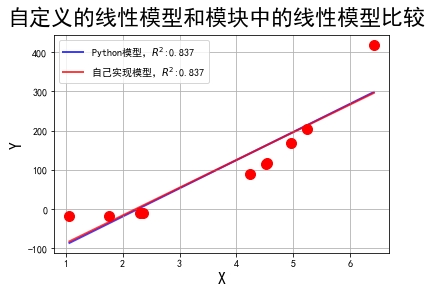

In [6]:
## 开始画图
plt.figure(facecolor='w')
plt.plot(x, y, 'ro', ms=10, zorder=3)
plt.plot(x_hat, y_hat, color='b', lw=2, alpha=0.75, label=u'Python模型，$R^2$:%.3f' % s1, zorder=1)
plt.plot(x_hat, y_hat2, color='r', lw=2, alpha=0.75, label=u'自己实现模型，$R^2$:%.3f' % s2, zorder=2)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)

plt.suptitle(u'自定义的线性模型和模块中的线性模型比较', fontsize=22)
plt.show()